# Kapitel 6: Verwendung von Klassifizierungsalgorithmen zur Einteilung von Text in mehrere Kategorien

## Setup
Es werden die Verzeichnisse festgelegt. Wenn Sie mit Google Colab arbeiten: Die erforderlichen Dateien werden kopiert und die erforderlichen Bibliotheken installiert.

## Hinweis

Mit ### ergänzte Code-Zeilen geben Werte an, die angepasst werden können.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch06/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Python-Einstellungen laden

Allgemeine Importe, Standardwerte für die Formatierung in Matplotlib, Pandas usw.

In [2]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# um die Ausgabe aller Anweisungen und nicht nur die letzte zu drucken
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# sonst wird der Text zwischen den $-Zeichen als Formel interpretiert und kursiv gedruckt
pd.set_option('display.html.use_mathjax', False)

# Pfad zum Importieren von Paketen
sys.path.append(BASE_DIR + '/packages')

In [3]:
import matplotlib.pyplot as plt
import html 
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

# Einführung in den Java Development Tools Bug Dataset

In [4]:
file = "eclipse_jdt.csv"
file = f"{BASE_DIR}/data/jdt-bugs-dataset/eclipse_jdt.csv.gz" 
df = pd.read_csv(file)
print (df.columns)
df[['Issue_id','Priority','Component','Title','Description']].sample(2, random_state=42)

Index(['Issue_id', 'Priority', 'Component', 'Duplicated_issue', 'Title',
       'Description', 'Status', 'Resolution', 'Version', 'Created_time',
       'Resolved_time'],
      dtype='object')


,Issue_id,Priority,Component,Title,Description
38438,239715,P3,UI,No property tester for TestCaseElement for property projectNature,I20080613-2000; ; Not sure if this belongs to JDT/Debug or Platform/Debug.; ; I saw this error message several times today in my error log but Im not yet sure how to reproduce it.; ; -- Error Deta...
44129,395007,P3,UI,[package explorer] Refresh action not available on Java package folders,M3.; ; F5 (Refresh) is available as a context menu entry for ordinary source folders but not for Java package folders in the e4 Java Package explorer.; ; Please restore the 3.x functionality.


In [5]:
df = df.drop(columns=['Duplicated_issue']) ###
pd.set_option('display.max_colwidth', -1)
df.sample(1, random_state=123).T

,11811
Issue_id,33113
Priority,P3
Component,Debug
Title,Evaluating for loop suspends in URLClassLoader
Description,Debug to a breakpoint in some HelloWorld program. In the DisplayView; highlight and ; Display the following code snippet:; ; for (int i = 0; i < 10; i++) {; System.out.println(i);; }; ; Instead of just reporting No explicit return value; the debugger suspends in the ; URLClassLoader; apparently trying to load the class int. You have hit Resume several ; more times before the evaluation completes. The DebugView does not indicate why it ; has stopped (the thread is just labelled Evaluating). This behavior does not happen if ; you turn of the Suspend on uncaught exceptions preference.
Status,VERIFIED
Resolution,FIXED
Version,2.1
Created_time,2003-02-25 15:40:00 -0500
Resolved_time,2003-03-05 17:11:17 -0500


<AxesSubplot:>

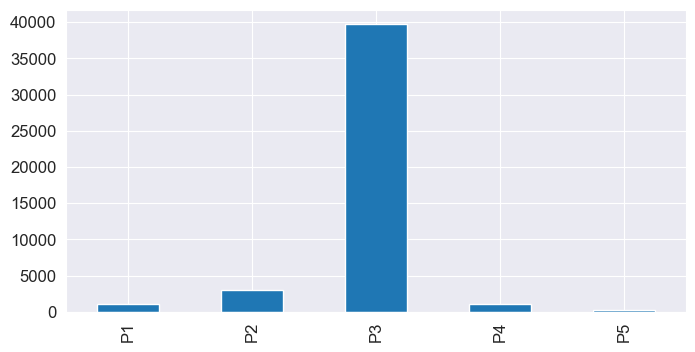

In [6]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

In [7]:
df['Component'].value_counts()

UI       17479
Core     13669
Debug    7542 
Text     5901 
APT      406  
Doc      299  
Name: Component, dtype: int64

# 1. Blueprint: Aufbau eines Textklassifizierungssystems

## Schritt 1: Datenvorbereitung

In [8]:
df = df[['Title','Description','Priority']]
df = df.dropna()
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title','Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

In [9]:
from blueprints.preparation import clean
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
df.sample(2, random_state=0)

,Priority,text
42439,P3,Regression in TypeHierarchyPerfTest#testOpenObjectHierarchy() I20110329-0800; ; http://download.eclipse.org/eclipse/downloads/drops/I20110329-0800/performance/eplnx2/Scenario415.html; ; The regression can be seen on all platforms.; ; Also TypeHierarchyPerfTest#testOpenCollHierarchy() shows erratic behavior on all platforms.
30486,P3,introduce indirection: misleading warning about duplicate method 3.2 M5 testing; ; have two classes; Foo and Bar; Foo with method m; refactor introduce indirection on m; warning: duplicate method m in declaring class (ok); change declaring class to Bar; ; the warning is still there; despite that Bar does not contain any methods; expected: the warning goes away as the declaring class is changed


## Schritt 2: Aufteilung von Training- und Testdaten

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  36040
Size of Test Data  9011


## Schritt 3: Training des maschinellen Lernmodells

In [11]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

In [12]:
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

## Schritt 4: Modellbewertung

In [13]:
X_test_tf = tfidf.transform(X_test)

In [14]:
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8761513705471091


In [15]:
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=42, strategy='most_frequent')

Accuracy Score -  0.8769281988680502


### Precision and Recall


In [16]:
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[  19,    1,  199,    4,    0],
       [   6,   18,  576,    8,    0],
       [   8,   48, 7827,   19,    0],
       [   0,    5,  192,   31,    0],
       [   0,    0,   50,    0,    0]], dtype=int64)

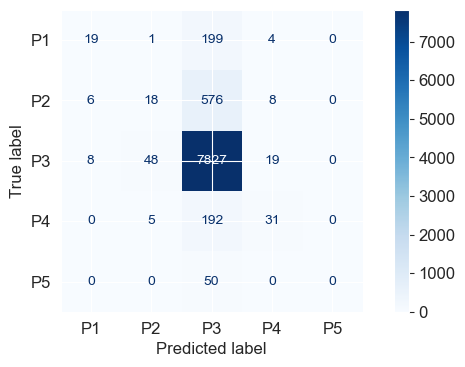

In [17]:
plot_confusion_matrix(model1,X_test_tf,
                      Y_test, values_format='d',
                      cmap=plt.cm.Blues)
plt.show()

In [18]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          P1       0.58      0.09      0.15       223
          P2       0.25      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



### Ungleichgewicht der Klassen


In [19]:
# Fehlerberichte mit Priorität P3 filtern und 4000 Zeilen daraus auswählen
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000, random_state=123)

# Erstellung eines separaten Data Frames, der alle anderen Fehlerberichte enthält
df_sampleRest = df[df['Priority'] != 'P3']

# Verkettung der beiden Data Frames, um den neuen Datensatz für ausgeglichene Fehlerberichte zu erstellen
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

# Prüfen Sie den Status des Klassenungleichgewichts
df_balanced['Priority'].value_counts()

P3    4000
P2    3038
P4    1138
P1    1117
P5    252 
Name: Priority, dtype: int64

# 2. Blueprint: Endgültiger Blueprint für die Textklassifizierung

In [20]:
# Laden des ausgeglichenen Data Frames

df = df_balanced[['text', 'Priority']]
df = df.dropna()

# Schritt 1: Datenvorbereitung

df['text'] = df['text'].apply(clean)

# Schritt 2: Aufteilung von Trainings- und Testdaten
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Schritt 3: Training des Machine Learning-Modells

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

# Schritt 4: Modellbewertung

X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  7636
Size of Test Data  1909


LinearSVC(random_state=0, tol=1e-05)

Accuracy Score -  0.5028810895756941
              precision    recall  f1-score   support

          P1       0.44      0.29      0.35       223
          P2       0.45      0.48      0.46       608
          P3       0.56      0.66      0.60       800
          P4       0.47      0.34      0.39       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.50      1909
   macro avg       0.38      0.35      0.36      1909
weighted avg       0.48      0.50      0.49      1909



In [21]:
clf = DummyClassifier(strategy='stratified', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=21, strategy='stratified')

Accuracy Score -  0.31691985332634887


In [22]:
## Erstellung eines Datenrahmen, der den Titel und die Beschreibung kombiniert, 
## tatsächliche und vorhergesagte Werte, die untersucht werden können
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred }
result = pd.DataFrame(frame)

result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] == result['predicted'])].sample(2, random_state=22)

,text,actual,predicted
8461,Variable view show old instance using build 20020917; ; Step to reproduce:; 1) create a selfhosting workspace (20020917).; 2) put a breakpoint in CompletionEngine at line 774 ; CompilationUnitDeclaration parsedUnit = parser.dietParse(...).; 3) create a launch configuration Runtime Workbench.; 4) launch this configuration in debugger.; 5) create a Java project.; 6) create a class.; 7) do ctrl+space in editor to hit breakpoint.; 8) look the id of the parser field of CompletionEngine in the variable view .; 9) step into parser.dietParse(...).; 10) in variable view the id of the parser is the same as step 8.; 11) do resume.; 12) do ctrl+space in editor to hit breakpoint.; 13) the id of the parser field is the same as step 8 (but it should not be the ; same instance of CompletionParser).; 14) step into parser.dietParse(...).; 15) the id of parser is a new id (as expected).; ; It seems that variable view doesnt show the right instance in the step 13.,P1,P1
34854,model proxy created for Java debug target in var view While investigating bug 177910; I found that the deltas for thread creation were duplicated in the output produced by Walter. I discovered that two model proxies are created for Java debug targets because the JavaModelProxyFactory does not limit the creation of proxies for targets to the debug view (as it should).,P2,P2


In [23]:
result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] != result['predicted'])].sample(2, random_state=33)

,text,actual,predicted
40065,Too many semicolons after constructor completion I20090611-1540; ; public class Try {; Object m() {; return null;; }; }; ; select null; type new Runna; Ctrl+Space; press Enter to select the anonymous proposal for Runnable(); ; => Result:; ; public class Try {; Object m() {; return new Runnable() {; ; public void run() {; // TODO Auto-generated method stub; ; }; };;;; };,P2,P3
7178,Next/Previous buttons have double image 20020606 XP; ; 1) Open Java editor; Outline; Search view; 2) Click in editor; click in outline; click in search; 3) Note that the show previous/ show next buttons have a double image.; Hover over the button and the imgae is corrected,P2,P3


# 3. Blueprint: Kreuzvalidierung

In [24]:
# Vektorisierung
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
df_tf = tfidf.fit_transform(df['text']).toarray()

# Kreuzvalidierung mit 5 Faltungen
scores = cross_val_score(estimator=model1,
                         X=df_tf,
                         y=df['Priority'],
                         cv=5)

print ("Validation scores from each iteration of the cross validation ", scores)
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())

Validation scores from each iteration of the cross validation  [0.48192771 0.45311682 0.43949712 0.42221058 0.37297014]
Mean value across of validation scores  0.43394447354635934
Standard deviation of validation scores  0.036211476115013436


## Hyperparameter-Tuning mit Gittersuche

In [25]:
### Achtung! Dauert lange ###

training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(
        stop_words="english")), ('model',
                                 LinearSVC(random_state=21, tol=1e-5))])

grid_param = [{
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__penalty': ['l2'],
    'model__loss': ['hinge'],
    'model__max_iter': [10000]
}, {
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__C': [1, 10],
    'model__tol': [1e-2, 1e-3]
}]

gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=2) ### Original: 5
gridSearchProcessor.fit(df['text'], df['Priority'])

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model',
                                        LinearSVC(random_state=21,
                                                  tol=1e-05))]),
             param_grid=[{'model__loss': ['hinge'], 'model__max_iter': [10000],
                          'model__penalty': ['l2'], 'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]},
                         {'model__C': [1, 10], 'model__tol': [0.01, 0.001],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]}])

Best alpha parameter identified by grid search  {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 6)}
Best result identified by grid search  0.4031439551795699


In [26]:
gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)
gridsearch_results[['rank_test_score', 'mean_test_score',
                    'params']].sort_values(by=['rank_test_score'])[:5]

,rank_test_score,mean_test_score,params
1,1,0.40,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 6)}"
3,2,0.40,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 6)}"
0,3,0.40,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}"
2,4,0.40,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 3)}"
9,5,0.39,"{'model__C': 1, 'model__tol': 0.001, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 6)}"


# 4. Blueprint: Verbesserte Textklassifizierung

In [27]:
### ACHTUNG!!! Dauert sehr lange


# Kennzeichnung zwischen SVC (True) und LinearSVC (False) 
runSVC = True

# Laden des Data Frames
file = f"{BASE_DIR}/data/jdt-bugs-dataset/eclipse_jdt.csv.gz" 
df = pd.read_csv(file)
df = df[['Title', 'Description', 'Component']]
df = df.dropna()
df['text'] = df['Title'] + df['Description']
df = df.drop(columns=['Title', 'Description'])

# Schritt 1: Datenvorbereitung
print("Schitt 1: Datenaufbereitung")
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]

if (runSVC):
    # Sample the data when running SVC to ensure reasonable run-times
    df = df.groupby('Component', as_index=False).apply(pd.DataFrame.sample,
                                                       random_state=42,
                                                       frac=.2)

# Schritt 2: Aufteilung von Training und Test
print("Schitt 2: Aufteilung in Trainings- und Testdaten")
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Component'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Component'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Schritt 3: Training des Machine Learning-Modells
print("Schitt 3: Trainingsphase")
tfidf = TfidfVectorizer(stop_words="english")

if (runSVC):
    model = SVC(random_state=42, probability=True)
    grid_param = [{
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__kernel': ['linear']
    }]
else:
    model = LinearSVC(random_state=42, tol=1e-5)
    grid_param = {
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__loss': ['hinge']
    }

training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words="english")), ('model', model)])

print("Vor Grid-Suche")
gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=2) ### sinvoll: 5

gridSearchProcessor.fit(X_train, Y_train)

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

best_model = gridSearchProcessor.best_estimator_

# Schritt 4: Modellbewertung
print("Schitt 4: Modell-Evaluation")
Y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Schitt 1: Datenaufbereitung
Schitt 2: Aufteilung in Trainings- und Testdaten
Size of Training Data  7208
Size of Test Data  1802
Schitt 3: Trainingsphase
Vor Grid-Suche


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             param_grid=[{'model__C': [1, 100], 'model__kernel': ['linear'],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]}])

Best alpha parameter identified by grid search  {'model__C': 1, 'model__kernel': 'linear', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 6)}
Best result identified by grid search  0.7121254162042175
Schitt 4: Modell-Evaluation
Accuracy Score -  0.7386237513873474
              precision    recall  f1-score   support

         APT       1.00      0.31      0.48        16
        Core       0.75      0.78      0.76       545
       Debug       0.90      0.77      0.83       300
         Doc       0.67      0.33      0.44        12
        Text       0.65      0.47      0.54       235
          UI       0.70      0.81      0.75       694

    accuracy                           0.74      1802
   macro avg       0.78      0.58      0.63      1802
weighted avg       0.74      0.74      0.73      1802



In [28]:
clf = DummyClassifier(strategy='most_frequent', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=21, strategy='most_frequent')

Accuracy Score -  0.3851276359600444


In [29]:
## Erstellung eines Data Frames, der den Titel und die Beschreibung kombiniert, 
## tatsächliche und vorhergesagte Werte, die untersucht werden
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred } 
result = pd.DataFrame(frame)

result[result['actual'] == result['predicted']].sample(2, random_state=21)

,,text,actual,predicted
2,43535,Cant remove breakpoint from breakpoints viewClicking on the Remove selected breakpoints button in the Breakpoints view is not removing any breakpoints.; ; I dont know if the is a JDT debug problem or a platform debug problem. I only have Java breakpoints; so I am raising the bug on JDT.; ; Using Eclipse 4.2M6,Debug,Debug
1,36831,Need to have local bindings created in error casesI20071113-0800; ; The following example shows that resolution of QualifiedAllocationExpression aborts to early and local type binding are not created. This is needed for bug 210070.; ; import java.io.Serializable;; ; public final class X implements Serializable {; ; void bar() {}; ; interface IM {}; class SMember extends String {}; ; @Annot(value = new SMember()); class Member extends X ; ZorkMember z;; void foo() {; this.bar();; Zork1 z;; ; }; ; @Annot(value = ; new X(){; ZorkAnonymous1 z;; void foo() {; this.bar();; Zork2 z;; }; }); void foo() {; new X().new IM();; class Local extends X ; ZorkLocal z;; void foo() {; this.bar();; Zork3 z;; }; }; new X() {; ZorkAnonymous2 z; ; void foo() {; this.bar();; Zork4 z;; }; };; }; }; @interface Annot {; String value();;,Core,Core


In [30]:
result[result['actual'] != result['predicted']].sample(2, random_state=42)

,,text,actual,predicted
1,3913,Code formatter should have option for not indending methods and fieldsBuild 20020228; ; The code formatter should have an option to avoid indenting members of the ; outermost class (you would still want to indent members of nested classes).; This was raised as a feature request at the TC; and its one Id also like to ; see. (I couldnt find an existing PR for it.),Core,UI
2,221,Ctrl-S does not work in the SnippetEditor (1GL1GH8)DS (10/3/01 3:58:22 PM); CTLR-S does not save in the snippet editor.; Should just add the snippet save action to the edit menu of the workbench like; the Java Editor; ; NOTES:,Debug,UI
